In [ ]:
#core
library(topicmodels)
library(tidytext)
library(tidyverse)
library(stringi)
#calculations
library(proxy)
library(ineq)
#trees
library(ggtree)
library(ape)
library(phylogram)
library(ggdendro)
#visuals
library(paletteer)
library(ggrepel)
library(plotly)
library(ggmosaic)
library(DT)
library(grid)


options(repr.plot.width = 10, repr.plot.height = 8)
source("src/poem_sampler.R")

In [3]:
# loads prepared LDA model
load("data/ru_lda.Rda")

# extract topic probabilities in documents
ru_gamma = tidy(ru_lda, matrix = "gamma")
# extract word probabilities in topics
ru_beta = tidy(ru_lda, matrix = "beta")

# get top 20 words per each topic
top_terms = ru_beta %>%
  group_by(topic) %>%
  top_n(20, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

# topic labels, top n words

n_words = 5

topic_labels = top_terms %>%
  group_by(topic) %>%
  top_n(n_words, beta) %>%
  summarise(label=paste(term, collapse=" ")) %>%
  mutate(label = paste(topic, label, sep="_"))



## 0. Preparations

In [54]:
#drop mysterious NA poems
ru_gamma = ru_gamma  %>% 
  filter(!str_detect(document, "^NA"))


### pull list of unique poems for later sampling, fix ids

unique_poems = ru_gamma  %>% 
    select(document) %>%
    unique()  %>% 
    separate(document, c("id", "author", "year", "meter", "clausula"), sep="_")  %>%
    ungroup()  %>% 
    mutate(id = row_number())


### get ru_gamma separated, add topic labels to it
### also redo fake ids into normal ids

ru_gamma_separated = ru_gamma  %>% 
    separate(document, c("id", "author", "year", "meter", "clausula"), sep="_")  %>% 
    left_join(topic_labels, by="topic")  %>% 
    mutate(id = rep(1:nrow(unique_poems), 80))


### get count of meters
meter_count = unique_poems  %>% 
    count(meter, sort=T)  %>% 
    filter(!str_detect(meter,"NA"))


### get count of metrical forms (meter + clausula)
meter_claus_count = unique_poems  %>% 
    unite("meter", meter:clausula)  %>% 
    count(meter, sort=T)  %>% 
    filter(!str_detect(meter,"NA_"))


### top5 most probable topics:

top5_topics = ru_gamma %>%
  group_by(topic) %>%
  summarise(mean_g = mean(gamma)) %>%
  arrange(-mean_g)  %>% 
  top_n(5, mean_g)  %>% 
  pull(topic)


## translation of labels

fam = meter_count  %>% 
 mutate(m_family = str_replace(meter, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"))  %>% 
 select(m_family)  %>% 
 rename(meter=m_family)

var = meter_claus_count  %>% 
 select(meter)

met = meter_count  %>% select(meter)
 
translation = fam  %>% bind_rows(var, met)  %>% mutate(meter_eng = str_replace_all(meter,c("Я" = "Iamb",
                                                                     "Х" = "Troch",
                                                                     "Ан" = "An",
                                                                      "Аф"  = "Amph",
                                                                    "Дк" = "Dk",
                                                                     "Д"  = "Dact",
                                                                     "ж" = "f",
                                                                      "м" = "m",
                                                                      "д" = "d",
                                                                      "Гек" = "Hex",
                                                                      "Тк" = "Tk",
                                                                      "вольн" = "free")))  %>% distinct()  %>% 
mutate(meter_eng = str_replace(meter_eng, "(\\d).*?(\\d)", "\\1\\2"))



save(top_terms, topic_labels, unique_poems, ru_gamma_separated, 
     meter_count, meter_claus_count, top5_topics, translation, file="data/lda_output.rda")


## 0.0. Meter distribution

In [23]:
unique_poems  %>% 
 mutate(m_family = str_replace(meter, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"))  %>% 
 count(m_family,sort=T)  %>% 
 filter(n>200)  %>% 
 filter(!m_family %in% c("Тк", "NA", "Л"))  %>% 
 mutate(rank = row_number())  %>% 
 mutate(m_family_eng=c("Iamb", "Trochee", "Anapest", "Amphibrach", "Dolnik", "Dactyl", "Hex"))

m_family,n,rank,m_family_eng
<chr>,<int>,<int>,<chr>
Я,21605,1,Iamb
Х,7758,2,Trochee
Ан,2622,3,Anapest
Аф,2560,4,Amphibrach
Дк,2278,5,Dolnik
Д,1445,6,Dactyl
Гек,223,7,Hex


Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


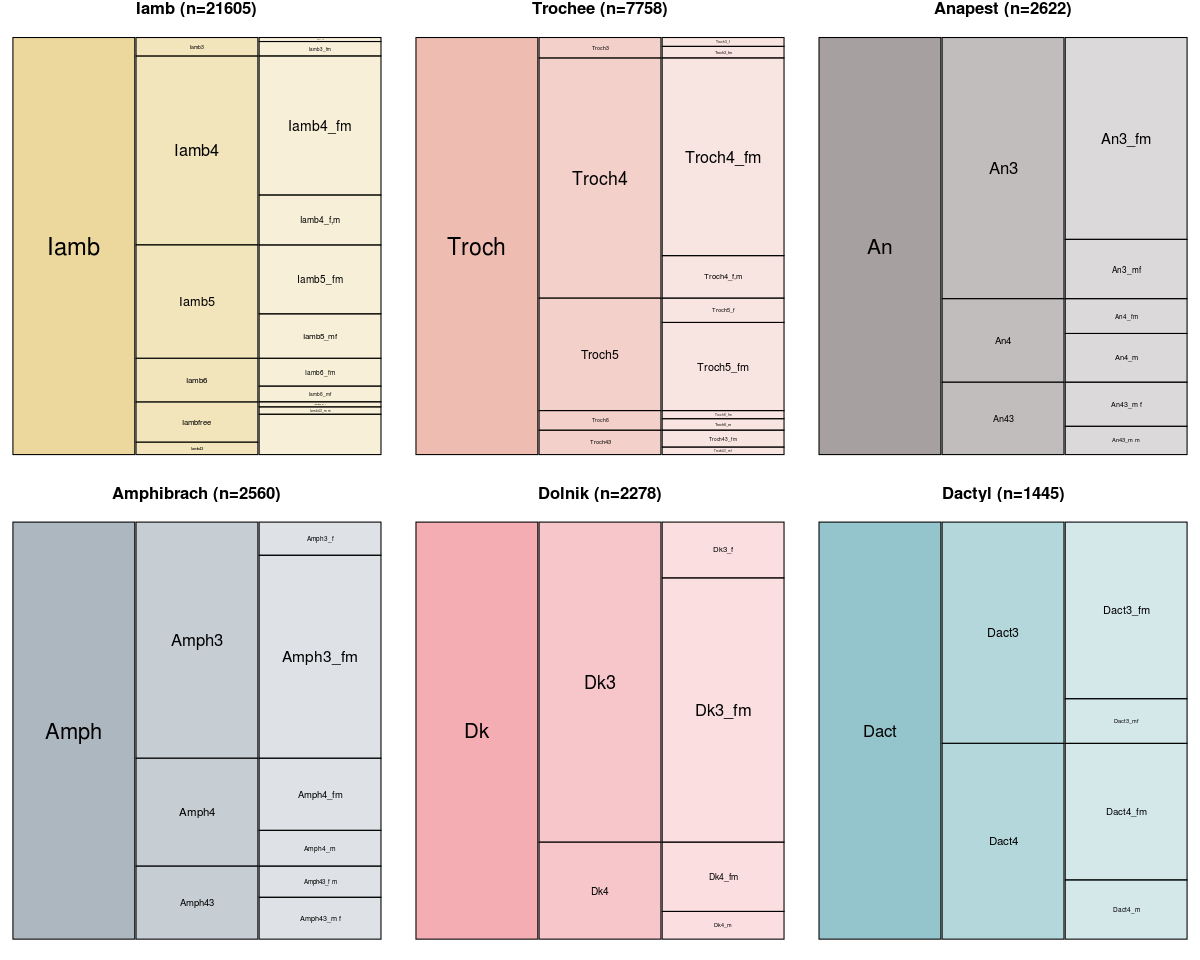

In [52]:
overall_counts = unique_poems  %>% 
 mutate(m_family = str_replace(meter, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"))  %>% 
 count(m_family,sort=T)  %>% 
 filter(n>200)  %>% 
 filter(!m_family %in% c("Тк", "NA", "Л"))  %>% 
 mutate(rank = row_number())  %>% 
 mutate(m_family_eng=c("Iamb", "Trochee", "Anapest", "Amphibrach", "Dolnik", "Dactyl", "Hex"))  %>% 
 rename(f_size=n)  %>% 
 mutate(label = paste(m_family_eng, " ", "(n=", f_size, ")", sep="")) # label for future plot

families_meters = unique_poems  %>%
  mutate(m_family = str_replace(meter, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"),
         clausula = str_replace(clausula, "вольн", "NA"),
         m_variant = paste(meter, clausula, sep="_"))  %>% 
         select(m_family,meter, m_variant)  %>%   filter(!str_detect(m_variant, "NA_NA")) %>% unique()


long = unique_poems %>% 
 mutate(clausula = str_replace(clausula, "вольн", "NA"),
        m_variant = paste(meter, clausula, sep="_"))  %>% 
 filter(!str_detect(m_variant, "NA_NA"))  %>%
 select(-meter)  %>%                                
 left_join(families_meters,by="m_variant")  %>%                                             
 group_by(meter)  %>% 
 mutate(n = max(row_number(meter)))  %>% 
 ungroup()  %>% 
 filter(n > 300)  %>% 
 select(m_family, meter, m_variant)  %>%
 gather(key="var", value="form", m_family:m_variant)  %>% 
 filter(var == "m_variant")  %>% 
 count(form,sort=T)  %>% 
 rename(m_variant = form)  %>% 
 left_join(families_meters, by="m_variant") %>% 
 group_by(meter)  %>% 
 mutate(var_rank = row_number())  %>% 
 filter(var_rank <= 2)  %>%
 mutate(n_meter = sum(n))  %>% 
 group_by(m_family)  %>% 
 mutate(n_family = sum(n))  %>% 
 ungroup()  %>% 
 select(m_variant,n, n_meter, n_family)  %>% 
 gather(key="var", value="count", n:n_family)  %>% 
 left_join(families_meters, by="m_variant")  %>% 
 mutate(m_variant = case_when(var == "n" ~ m_variant,
                              var == "n_meter" ~ meter,
                              var == "n_family" ~ m_family)) %>% 
 select(-meter)  %>% 
 unique()  %>% 
 left_join(overall_counts, by="m_family")  %>% 

 rename(form = m_variant, n=count, family=m_family)  %>% 
 mutate(var = fct_relevel(var, c("n_family", "n_meter", "n")))

translation  %>% rename(form = meter)  %>% 
    right_join(long,by="form")  %>%   
    mutate(meter_eng = str_replace_all(meter_eng, c("Iamb43" = "Iаmb43",# very illegal character manip from cyrillic to latin for ordering
                                                    "Troch43" = "Trоch43",# very illegal character manip from cyrillic to latin for ordering
                                                    "An43" = "Аn43",# very illegal character manip from cyrillic to latin for ordering
                                                     "Amph43" = "Аmph43")))  %>% # very illegal & cursed character manip from cyrillic to latin for ordering
    ggplot(aes(var,n,group=meter_eng)) + 
    geom_bar(aes(fill=family,alpha=reorder(var,n)), stat="identity",color="black",size=0.3,width=0.99) +
    geom_text(aes(label=meter_eng,size=n/f_size),position=position_stack(vjust=0.5)) + 
    scale_fill_paletteer_d("ghibli::PonyoLight") + theme_void() + 
    guides(fill=F, alpha=F,size=F) + 
    facet_wrap(~reorder(label,rank),scales="free") +
    theme(strip.text.x = element_text(size = 10,face = "bold")) +
    scale_alpha_discrete(range = c(0.4, 1)) +
    scale_size_continuous(range = c(0.2, 5))



In [53]:
ggsave("plots/fig1_meter_relative.png", height = 5, width = 8)

Warning message:
“Removed 1 rows containing missing values (geom_text).”


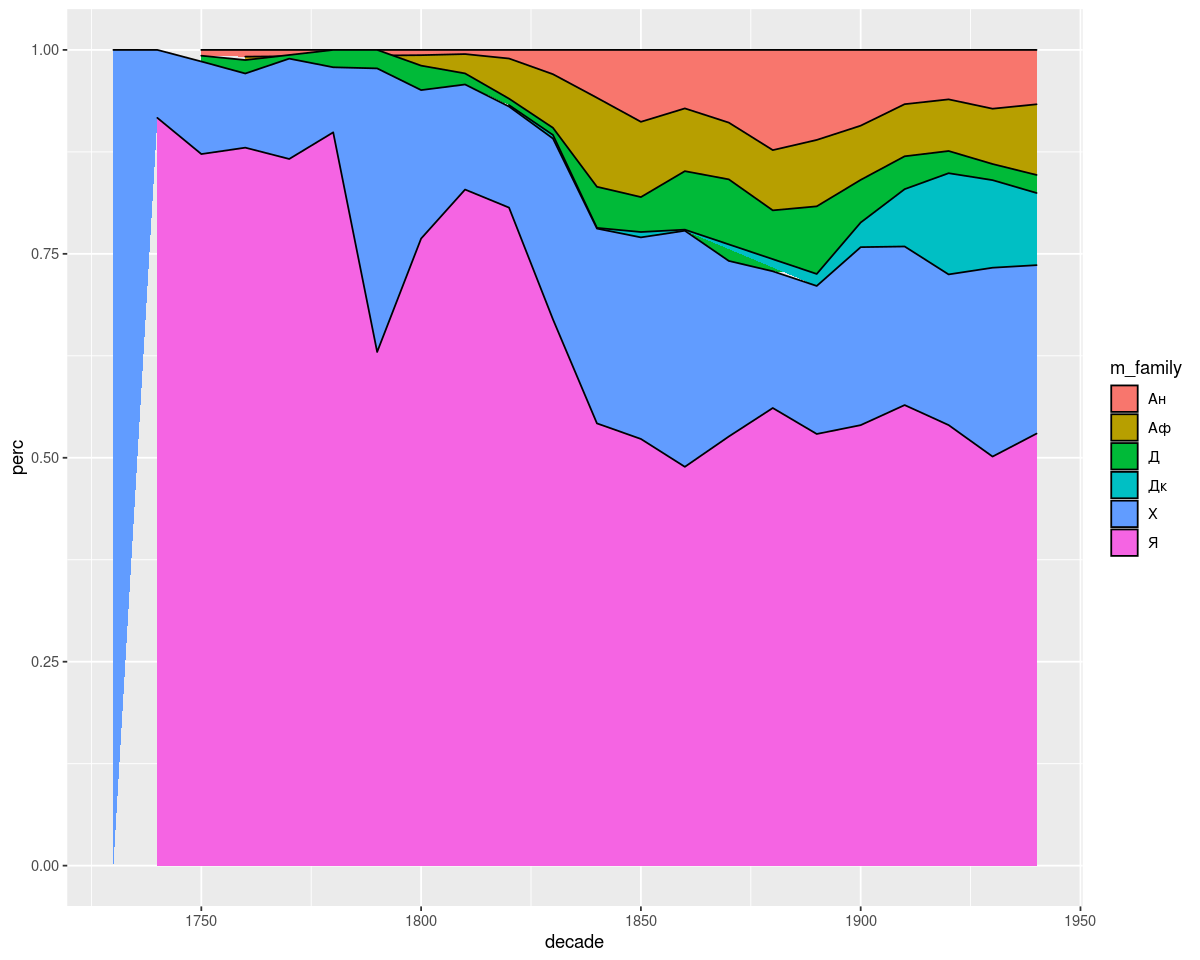

In [48]:
overall_counts = unique_poems  %>% 
 mutate(m_family = str_replace(meter, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"))  %>% 
 count(m_family,sort=T)  %>% 
 filter(n>200)  %>% 
 filter(!m_family %in% c("Тк", "NA", "Л", "Гек"))  %>% 
 mutate(rank = row_number())

counts_year = unique_poems  %>% 
 mutate(m_family = str_replace(meter, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"))  %>% 
 right_join(overall_counts,by="m_family")

counts_year  %>% 
mutate(decade = floor(as.numeric(year)/10)*10)  %>% 
count(decade, m_family)  %>% 
group_by(decade)  %>% 
mutate(perc = n/sum(n))  %>% 
ggplot(aes(decade,perc,group=m_family,fill=m_family)) + geom_density(stat="identity",position="fill",alpha=1)


central_points = counts_year  %>% 
mutate(decade = floor(as.numeric(year)/10)*10)  %>% 
count(decade, m_family)  %>% 
group_by(decade)  %>% 
mutate(perc = n/sum(n))  %>% 
group_by(m_family)  %>% 
summarise(mean_dec = median(decade))

## 0.1. Get some visualizations of random topics

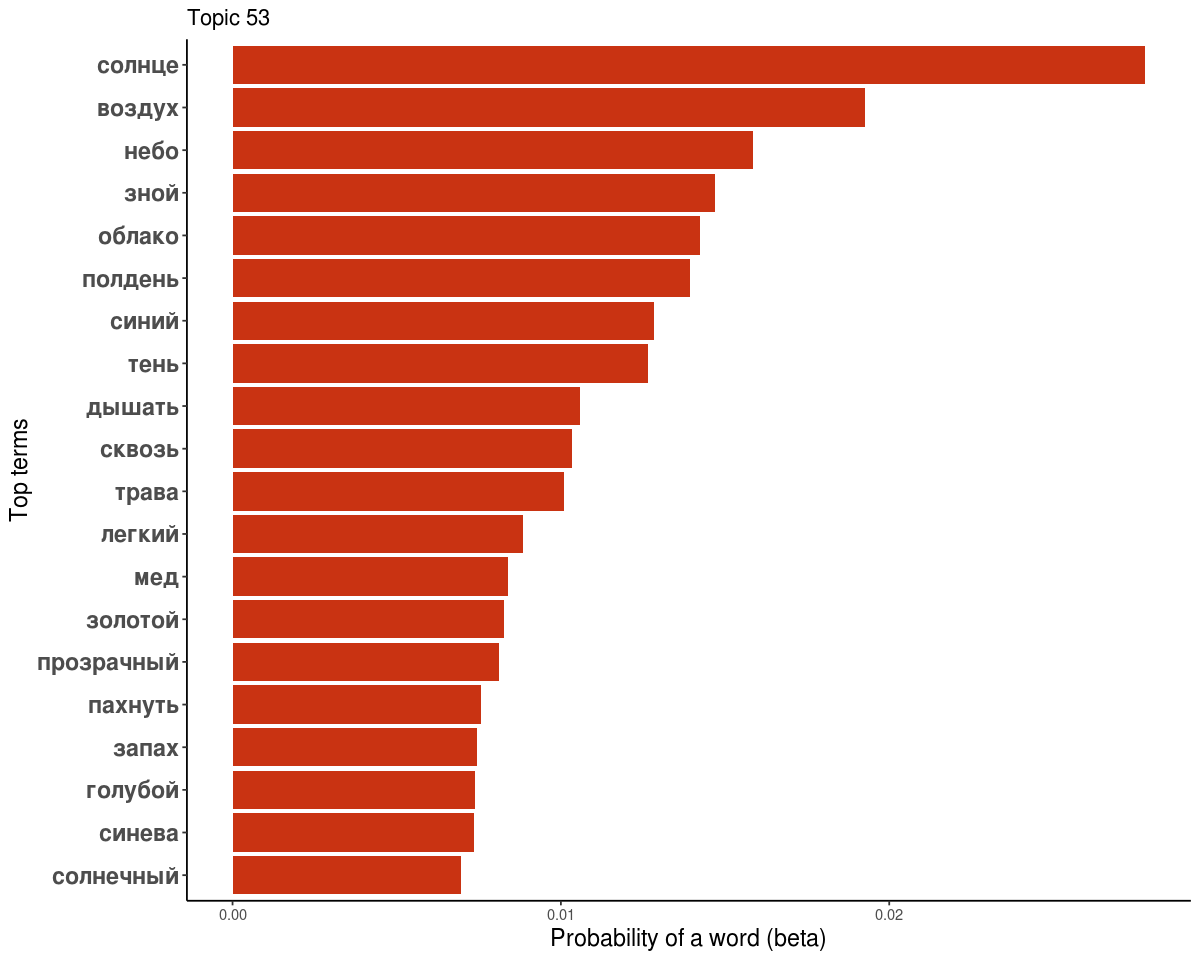

In [3]:
## r
load("data/lda_output.rda")
## 

rand_theme = sample(c(1:80), 1)

top_terms %>%
  filter(topic == rand_theme) %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  labs(y="Probability of a word (beta)",
       x="Top terms") +
  coord_flip() +
  theme_classic() +
      theme(
        axis.text.y = element_text(size=14,face = "bold"),
         axis.title=element_text(size=14)) +
#  scale_fill_paletteer_d(wesanderson, Royal1)
  scale_fill_manual(values=paletteer_d("wesanderson::Royal1")[2]) +
    labs(title = paste("Topic", rand_theme, sep=" "))


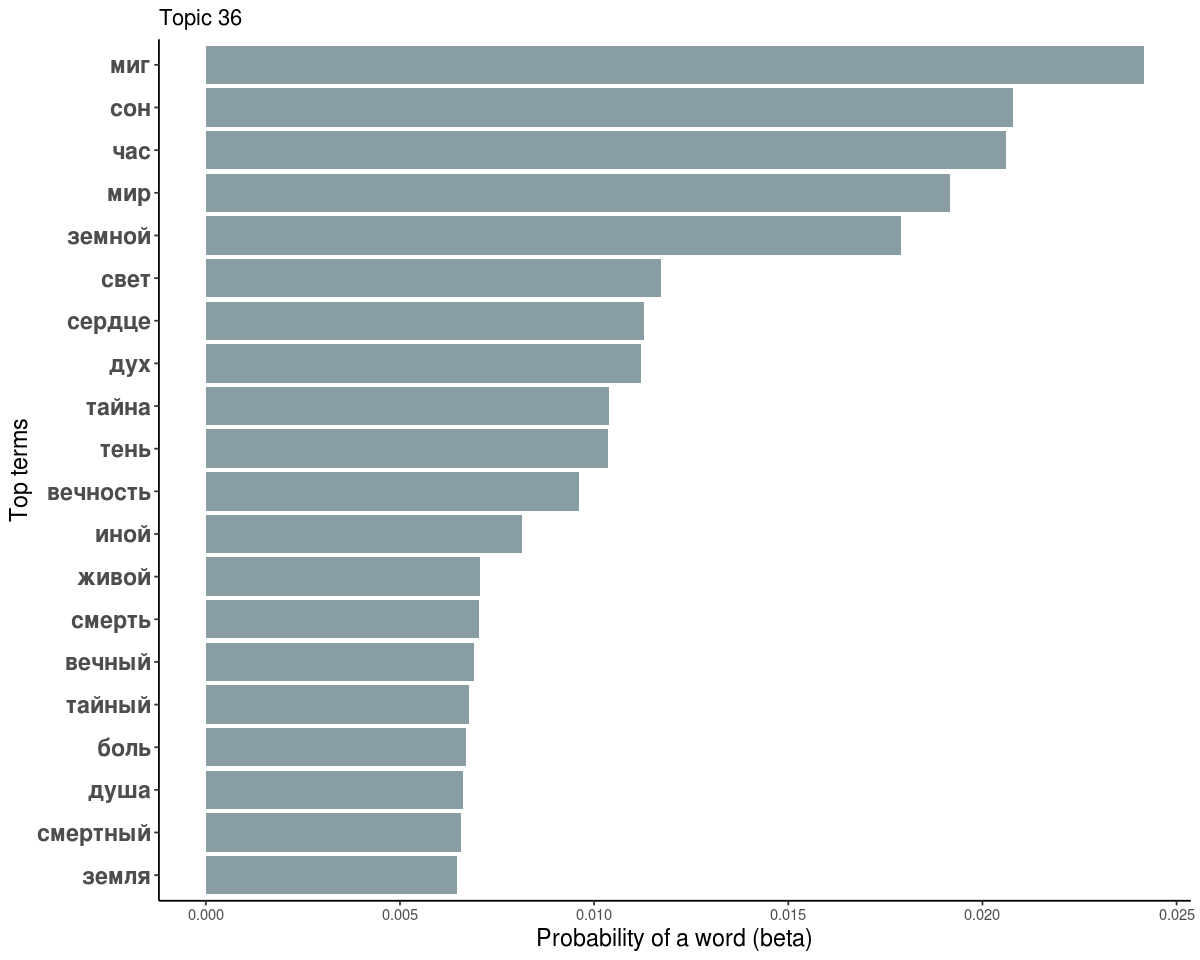

In [53]:
rand_theme = sample(c(1:80), 1)

top_terms %>%
  filter(topic == rand_theme) %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  labs(y="Probability of a word (beta)",
       x="Top terms") +
  coord_flip() +
  theme_classic() +
      theme(
        axis.text.y = element_text(size=14,face = "bold"),
         axis.title=element_text(size=14)) +
#  scale_fill_paletteer_d(wesanderson, Royal1)
  scale_fill_manual(values=paletteer_d("wesanderson::Royal1")[1]) +
  labs(title = paste("Topic", rand_theme, sep=" "))

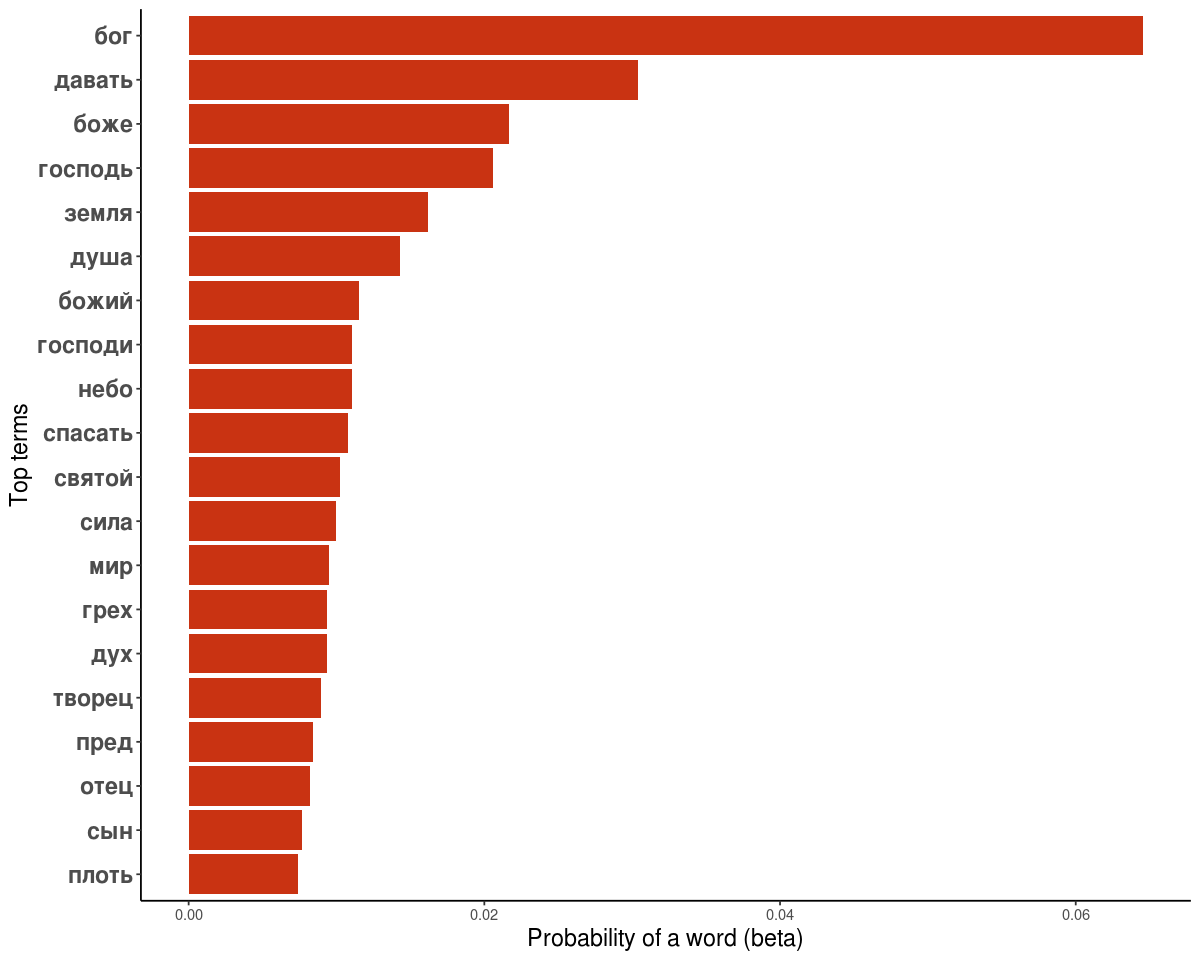

In [54]:
rand_theme = sample(c(1:80), 1)

top_terms %>%
  filter(topic == rand_theme) %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  labs(y="Probability of a word (beta)",
       x="Top terms") +
  coord_flip() +
  theme_classic() +
      theme(
        axis.text.y = element_text(size=14,face = "bold"),
         axis.title=element_text(size=14)) +
  scale_fill_manual(values=paletteer_d("wesanderson::Royal1")[2])

## 0.2. Documents as topics

id,author,year,meter,clausula,topic,gamma,label
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>
38833,М.Ю.Лермонтов,1841,Х5,жм,5,0.06029412,5_вода ручей роща луг лес
38833,М.Ю.Лермонтов,1841,Х5,жм,21,0.11911765,21_сон спать ночь просыпаться утро
38833,М.Ю.Лермонтов,1841,Х5,жм,31,0.22205882,31_идти путь дорога проходить нога
38833,М.Ю.Лермонтов,1841,Х5,жм,56,0.22205882,56_луна ночь звезда небо месяц
38833,М.Ю.Лермонтов,1841,Х5,жм,67,0.07500000,67_сердце свет зреть жить любовь


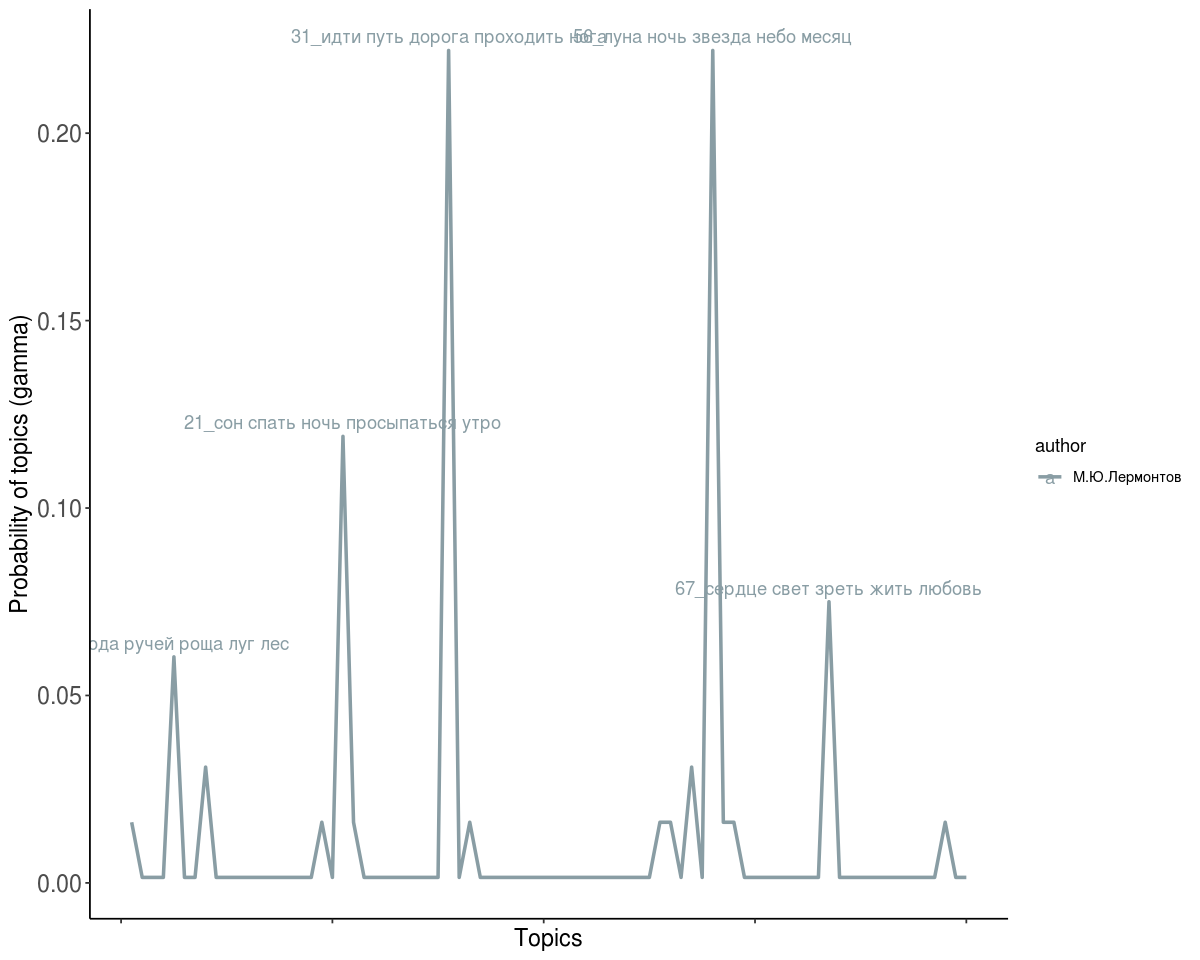

In [65]:
top_topics = ru_gamma_separated  %>% 
  filter(id == "38833")  %>% 
  filter(gamma > 0.05)
top_topics

ru_gamma_separated  %>% 
  filter(id == "38833")  %>% 
  ggplot(aes(topic, gamma, group=author, color=author)) +
  labs(x="Topics",
       y="Probability of topics (gamma)") +
  geom_line(size=1) +
  theme_classic() +


 geom_text(data = top_topics, 
            aes(label=factor(label), vjust=-0.5)) +
  theme(axis.text.x = element_blank(),
        axis.text.y = element_text(size=14),
        axis.title=element_text(size=14)) +


  scale_color_paletteer_d("wesanderson::Royal1")



In [19]:
ru_gamma_separated

id,author,first_line,meter,clausula,topic,gamma,label
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>
1,Клушин А.И.,Не-титла-знамениты,NA,NA,1,0.0031250000,1_дождь капля дождик серый небо
2,Ржевский А.А.,Случилося-двоим,Явольн,вольн,1,0.0009523810,1_дождь капля дождик серый небо
3,Цветаева М.И.,Вы-идущие-мимо-меня,Ан3,мж,1,0.0021739130,1_дождь капля дождик серый небо
4,Муравьев М.Н.,Успех-твой-первый-возвещая,Я4,жм,1,0.0005494505,1_дождь капля дождик серый небо
5,Сумароков А.П.,Не-гордитесь-красны-девки,NA,NA,1,0.0031250000,1_дождь капля дождик серый небо
6,Попугаев В.В.,Ликуй-Парнас-всплещите-музы,Я4,жм,1,0.0014084507,1_дождь капля дождик серый небо
7,Муравьев М.Н.,Как-яры-волны-в-море-плещут,Я4,жжм,1,0.0009090909,1_дождь капля дождик серый небо
8,Муравьев М.Н.,Сей-непорочнейшей-я-кровию-доселе,Я6,жжмм,1,0.0034482759,1_дождь капля дождик серый небо
9,Блок А.А.,Ты-была-светла-до-странности,Х4,дм,1,0.0023255814,1_дождь капля дождик серый небо


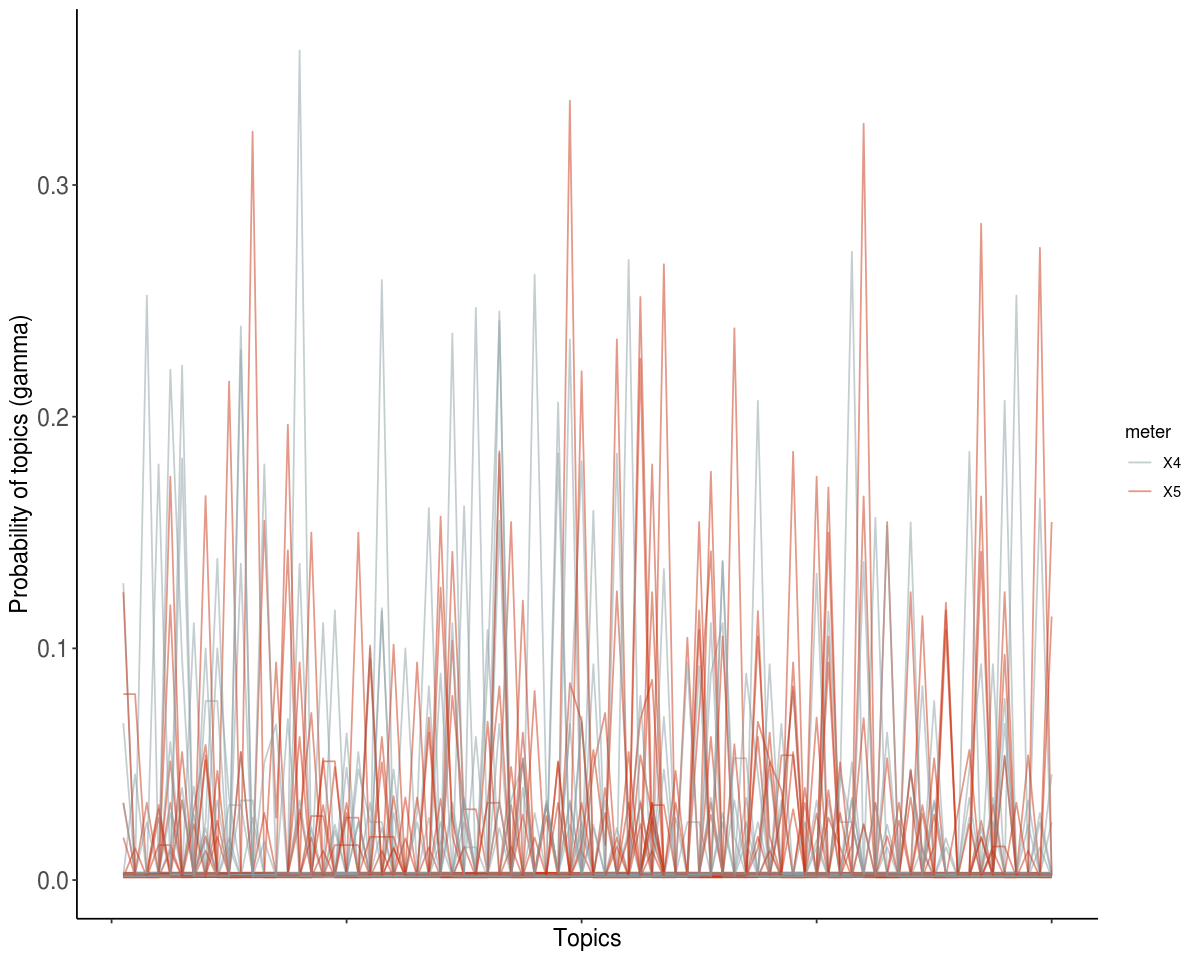

In [66]:
 two_meters = unique_poems %>%
    unite("m_form", meter:clausula)  %>% 
    filter(m_form %in% c("Х5_жм", "Х4_дм")) %>% 
    group_by(m_form)  %>% 
    sample_n(20) %>% 
    ungroup()  %>% 
    select(id)


ru_gamma_separated  %>% 
  right_join(two_meters, by="id") %>%
  ggplot(aes(topic, gamma, group=id, color=meter)) +
  labs(x="Topics",
       y="Probability of topics (gamma)") +
  geom_line(alpha=0.5) +
  theme_classic() +

  theme(axis.text.x = element_blank(),
        axis.text.y = element_text(size=14),
        axis.title=element_text(size=14)) +


  scale_color_paletteer_d("wesanderson::Royal1")
    

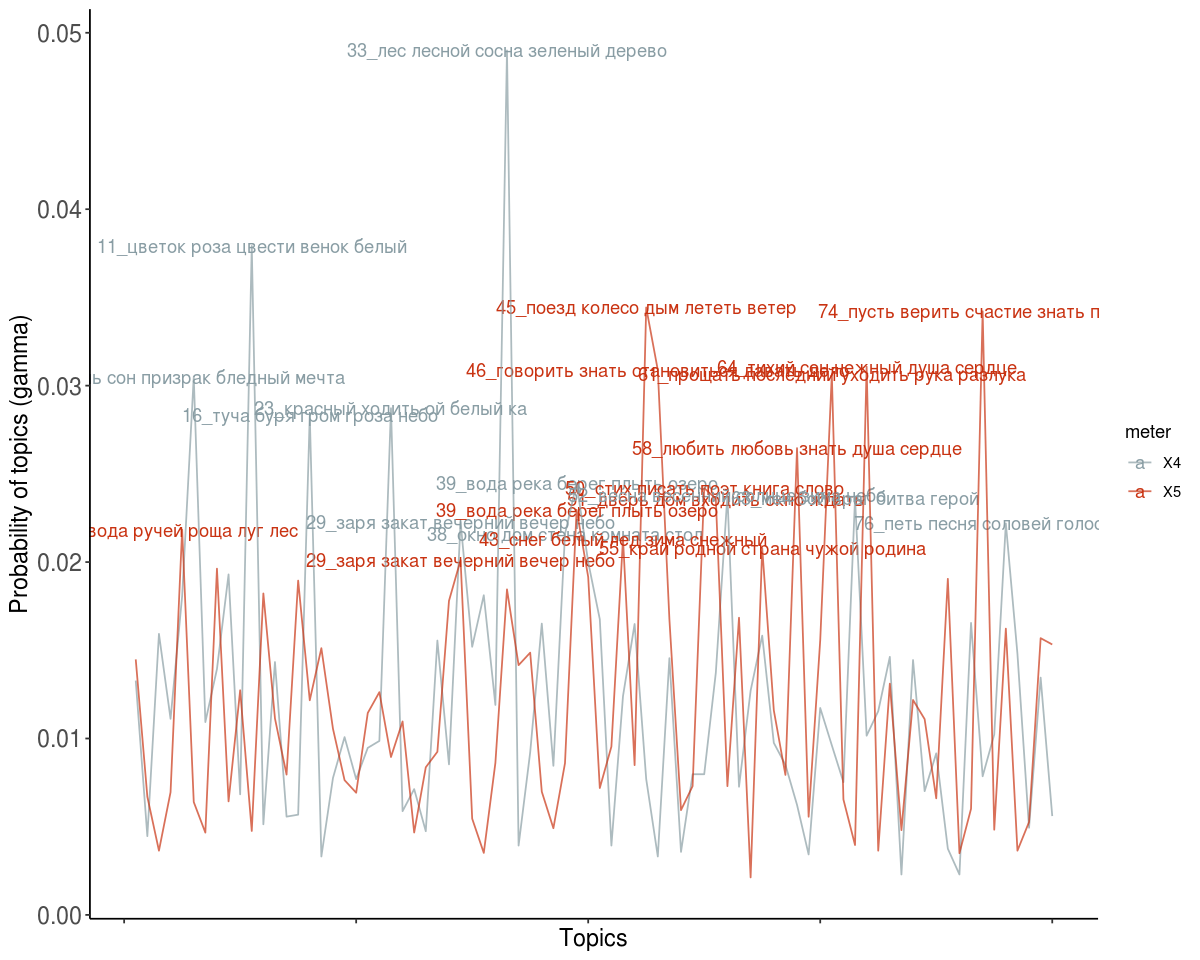

In [68]:
ru_gamma_separated  %>% 
  right_join(two_meters, by="id") %>%
  group_by(topic,label, meter)  %>% 
  summarise(m_gamma = mean(gamma))  %>% 
  ggplot(aes(topic, m_gamma, group=meter, color=meter)) +
  geom_text(data = .  %>% filter(m_gamma > 0.02), aes(label=label), vjust=0.5) +
  labs(x="Topics",
       y="Probability of topics (gamma)") +
  geom_line(alpha=0.7) +
  theme_classic() +

  theme(axis.text.x = element_blank(),
        axis.text.y = element_text(size=14),
        axis.title=element_text(size=14)) +


  scale_color_paletteer_d("wesanderson::Royal1")
    

In [25]:
ru_gamma_separated   %>% 
  filter(meter=="Явольн")  %>% 
  group_by(topic,label) %>% 
  summarise(m_gamma = mean(gamma))  %>% 
  arrange(-m_gamma)  %>%
  ungroup()

topic,label,m_gamma
<int>,<chr>,<dbl>
46,46_говорить знать становиться давать дело,0.14669270
48,48_лев волк собака зверь пес,0.04466331
67,67_сердце свет зреть жить любовь,0.03362481
44,44_душа любовь мечта счастие сердце,0.02129704
27,27_нога сидеть рука нос глаз,0.01952145
26,26_хлеб жить давать труд горе,0.01821041
24,24_поэт муза стих лира певец,0.01785434
75,75_царь народ слава русский россия,0.01654320
77,77_дело взять давать товарищ самый,0.01648975


## 01. Equal sample meters and get Trochee-5 z-scores

what we are doing here is looking at distinctive topics for random sample of Trochee-5 in the context of equal samples of other meters popular enough.

1) Sample n (200) poems from meters that have at least n*2 poems;  
2) Measure zscores (normalized deviation from the mean) for summarised gamma for each meter sample

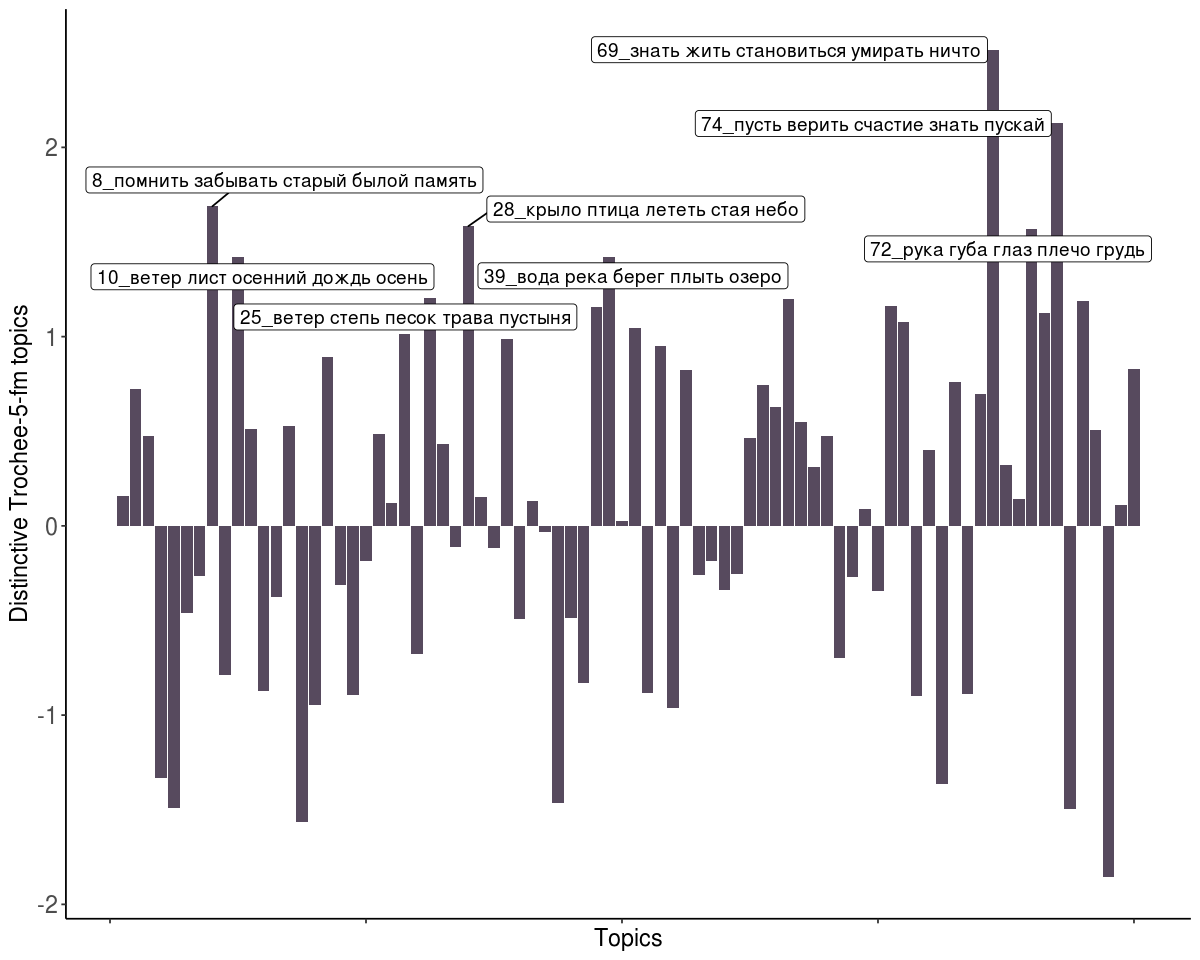

In [6]:

#sample 100 poems per eligible metrical form
sample = poem_sampler(unique_poems  %>% unite("meter", meter:clausula),
                     meter_claus_count,
                     sample_size=500,
                     n_samples = 1,
                     meter_count_limit = 600)

## filter gamma table based on sample and calculate z-scores
trochee5z = ru_gamma_separated  %>% 
    right_join(sample,by="id")  %>% 
    group_by(meter,clausula,topic, label)  %>% 
    summarise(m_gamma = mean(gamma))  %>% 
    group_by(topic)  %>% 
    mutate(mean_gamma = mean(m_gamma),
           sd = sd(m_gamma))  %>% 
    ungroup()  %>% 
    mutate(zscore = (m_gamma - mean_gamma) / sd)  %>% 
    filter(meter == "Х5" & clausula == "жм")


## plot deviation of topics
trochee5z  %>% 
  ggplot(aes(topic, zscore)) +
  labs(x="Topics",
       y="Distinctive Trochee-5-fm topics") +
  geom_col(fill=paletteer_d("ghibli::LaputaDark")[5]) +
  theme_classic() +
  geom_label_repel(data=trochee5z  %>% filter(zscore > 1.2), aes(label=label),size=4) +
  theme(axis.text.x = element_blank(),
        axis.text.y = element_text(size=14),
        axis.title=element_text(size=14))


In [21]:

trochee5z = ru_gamma_separated  %>% 
#    right_join(sample,by="id")  %>% 
    group_by(meter,clausula,topic, label)  %>% 
    summarise(m_gamma = mean(gamma))  %>% 
    group_by(topic)  %>% 
    mutate(mean_gamma = mean(m_gamma),
           sd = sd(m_gamma))  %>% 
    mutate(zscore = (m_gamma - mean_gamma) / sd)  %>% 
    ungroup()  %>% 
    filter(meter == "Х5" & clausula == "жм")  %>% 
    
    top_n(10, zscore)  %>% 
    arrange(-zscore)

trochee5z

troch3fm = ru_gamma_separated  %>% 
#    right_join(sample,by="id")  %>% 
    group_by(meter,clausula,topic, label)  %>% 
    summarise(m_gamma = mean(gamma))  %>% 
    group_by(topic)  %>% 
    mutate(mean_gamma = mean(m_gamma),
           sd = sd(m_gamma))  %>% 
    mutate(zscore = (m_gamma - mean_gamma) / sd)  %>% 
    ungroup()  %>% 
    filter(meter == "Х3" & clausula == "жм")  %>% 
    
    top_n(10, zscore)  %>% 
    arrange(-zscore)
troch3fm

i4dm = ru_gamma_separated  %>% 
#    right_join(sample,by="id")  %>% 
    group_by(meter,clausula,topic, label)  %>% 
    summarise(m_gamma = mean(gamma))  %>% 
    group_by(topic)  %>% 
    mutate(mean_gamma = mean(m_gamma),
           sd = sd(m_gamma))  %>% 
    mutate(zscore = (m_gamma - mean_gamma) / sd)  %>% 
    ungroup()  %>% 
    filter(meter == "Я4" & clausula == "дм")  %>% 
    
    top_n(10, zscore)  %>% 
    arrange(-zscore)

i4dm

meter,clausula,topic,label,m_gamma,mean_gamma,sd,zscore
<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Х5,жм,69,69_знать жить становиться умирать ничто,0.02281111,0.013388853,0.03316056,0.2841405
Х5,жм,41,41_война идти солдат бой пуля,0.01949427,0.010867316,0.03097534,0.2785104
Х5,жм,61,61_прощать последний уходить рука разлука,0.01730549,0.011316822,0.02993325,0.2000674
Х5,жм,25,25_ветер степь песок трава пустыня,0.01589519,0.010723448,0.02878867,0.1796450
Х5,жм,50,50_стих писать поэт книга слово,0.01443754,0.009979493,0.02543933,0.1752424
Х5,жм,66,66_сад зеленый лист ветка липа,0.01535562,0.011162159,0.02661399,0.1575659
Х5,жм,45,45_поезд колесо дым лететь ветер,0.01396029,0.009827926,0.02651045,0.1558767
Х5,жм,38,38_окно дом стена комната стол,0.01770850,0.012763386,0.03294444,0.1501046
Х5,жм,39,39_вода река берег плыть озеро,0.01565739,0.011505962,0.02927263,0.1418194


meter,clausula,topic,label,m_gamma,mean_gamma,sd,zscore
<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Х3,жм,76,76_петь песня соловей голос песнь,0.02516507,0.01291970,0.03088095,0.3965346
Х3,жм,77,77_дело взять давать товарищ самый,0.02240880,0.01200548,0.03345742,0.3109421
Х3,жм,23,23_красный ходить ой белый ка,0.03443248,0.01914267,0.05187916,0.2947198
Х3,жм,43,43_снег белый лед зима снежный,0.02182803,0.01282861,0.03296896,0.2729664
Х3,жм,51,51_дверь дом входить окно ждать,0.01842918,0.01097084,0.02848014,0.2618787
Х3,жм,33,33_лес лесной сосна зеленый дерево,0.02098907,0.01236671,0.03398144,0.2537376
Х3,жм,10,10_ветер лист осенний дождь осень,0.02060468,0.01303796,0.03204767,0.2361084
Х3,жм,21,21_сон спать ночь просыпаться утро,0.01832547,0.01223944,0.02673918,0.2276071
Х3,жм,22,22_ночь ночной тьма мрак темный,0.01780781,0.01182553,0.02762171,0.2165789


meter,clausula,topic,label,m_gamma,mean_gamma,sd,zscore
<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Я4,дм,62,62_город башня стена камень каменный,0.01590475,0.010072424,0.02408776,0.2421281
Я4,дм,59,59_страшный смерть ужас злой кровь,0.01828980,0.011569931,0.02830413,0.2374164
Я4,дм,1,1_звезда мир небо земля бездна,0.01817200,0.011735652,0.02717836,0.2368189
Я4,дм,6,6_тень сон призрак бледный мечта,0.02275904,0.014880588,0.03919456,0.2010088
Я4,дм,4,4_душа мечта красота мир сила,0.01795540,0.012165338,0.02923597,0.1980460
Я4,дм,68,68_час ждать прийти скоро иль,0.01705255,0.011836069,0.02990059,0.1744607
Я4,дм,12,12_бог храм царь пред мир,0.01955675,0.013803134,0.03363673,0.1710516
Я4,дм,61,61_прощать последний уходить рука разлука,0.01622934,0.011316822,0.02993325,0.1641156
Я4,дм,80,80_город улица дом фонарь идти,0.01653590,0.011723727,0.02939615,0.1637008
